# A.1 Homogeneous Transformations

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation
%matplotlib widget
np.set_printoptions(precision=1, suppress=True)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

## Transforms

Look like `scipy` has a spatial transform library that we can take advantage of here.

The `Rotation` class makes an array of rotation matrices.  Here, is an example of an array of 2 rotation matrices:

In [2]:
Rx01 = Rotation.from_euler('xyz', np.array([[0, 0, 0], [45, 0, 45]]), degrees=True)
R01 = Rx01.as_matrix()
print(f"R01 shape {R01.shape}")

R01 shape (2, 3, 3)


The shape of the array of rotation matrices is $(n, r, c) = (n, 3, 3)$ where $n$ is the number of rotation matrices. We turn these into an array of 4x4 homogeneous transformation matrices by:

1. Concatenating with a 1x3 row along axis 1 (row axis).
2. Concatenating with a 4x1 column along axis 2 (column axis).

Here is an example:

In [3]:
M34=np.concatenate([R01,np.zeros((R01.shape[0], 1,3))], axis=1)
T01=np.concatenate([M34, np.array(R01.shape[0]*[[[0],[0],[0],[1]]])], axis=2)
np.set_printoptions(precision=1, suppress=True)
print(M34)

[[[ 1.   0.   0. ]
  [ 0.   1.   0. ]
  [ 0.   0.   1. ]
  [ 0.   0.   0. ]]

 [[ 0.7 -0.5  0.5]
  [ 0.7  0.5 -0.5]
  [ 0.   0.7  0.7]
  [ 0.   0.   0. ]]]


The functions below capture this.

In [4]:
def rotation_matrix(eulers):
    """
    Returns a rotation matrix (or matrices) from Euler angles
    (or a list/array of Euler angles).
    """
    R01 = Rotation.from_euler('xyz', eulers, degrees=True)
    T01 = R01.as_matrix()
    return T01

In [5]:
def htm(rm, dv):
    """
    Function to turn rotation matrix and displacement vector
    into a homogenous transformation matrix.  Handles a list
    or a list of rotation and displacement vectors.
    
    To move a point p_new = T x homogenous coordinate (4).
       Given this order of multimplication:
       1. Rotation ... then
       2. displacement
       
    """
    assert len(rm.shape) == len(dv.shape), f"Dimensions must match d(rm)={len(rm.shape)} but d(dv)={len(dv.shape)}"
    wrm, wdv  = rm, dv
    if len(rm.shape) == 2:
        wrm, wdv = np.array([rm]), np.array([dv])
    M34=np.concatenate([wrm, wdv], axis=2)
    new_row = np.array(M34.shape[0]*[[[0, 0, 0, 1]]])
    M44=np.concatenate([M34, new_row], axis=1)
    if len(rm.shape) == 2:
        M44 = M44[0]
    return M44
    

In [6]:
R_50 = rotation_matrix([0,0,50])

In [7]:
dv=np.array([[1,-.5,0]]).T

In [8]:
Th = htm(R_50, dv)

In [9]:
p0 = np.array([[1,0,0,1]]).T;print(*p0[:2])
p0_50 = R_50@p0[:3]
p0_rdv = p0_50+dv[:3]

[1] [0]


In [10]:
p0_hT = Th@p0

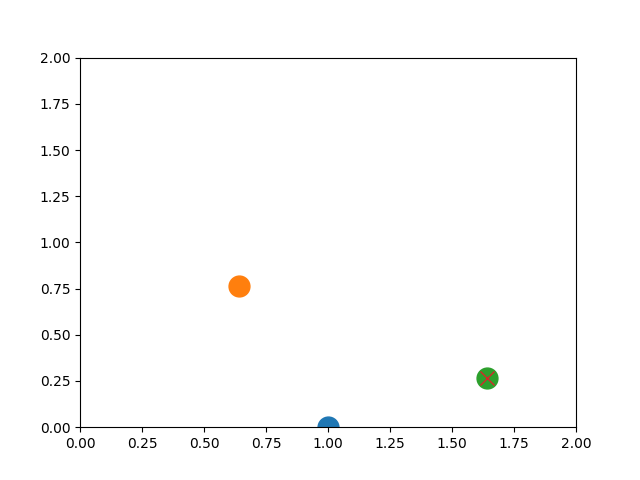

In [11]:
ax = plt.figure().add_subplot()
ax.plot(*p0[:2],'o',ms=15)
ax.plot(*p0_50[:2],'o',ms=15)
ax.plot(*p0_rdv[:2],'o',ms=15)
ax.plot(*p0_hT[:2],'x',ms=10)
ax.set_xlim([0.,2.]); ax.set_ylim([0,2.])
plt.show()

## 3D Plotting

Let's make the arm in space.

In [12]:
isin = lambda x: np.arcsin(x)*180./np.pi

def ijk():
    return np.array([[1.,0,0]]), np.array([[0,1.,0]]), np.array([[0,0,1.]])

In [13]:
vv=np.array([[1,1,2]])/np.sqrt(6)
vxz=np.array([[1,0,2]])/np.sqrt(5)
x,y,z = ijk()

print(vv);print(x)
print(np.cross(vv, x))
print(y)
print(isin(np.dot(y,np.cross(vv, x).T)[0,0]))
print(isin(np.dot(y,np.cross(vv, z).T)[0,0]))
#print(np.cross(vv,x))
#print(np.cross(vv,x]))
#print(np.cross(vxz,xyz[0])[0][1])
#print(np.cross(vxz,xyz[2])[0][1])


[[0.4 0.4 0.8]]
[[1. 0. 0.]]
[[ 0.   0.8 -0.4]]
[[0. 1. 0.]]
54.73561031724536
-24.094842552110702


In [14]:
class PlaneJ2:
    z_0 = -44.2
    
    def __init__(self):
        self.points = self._gen_points()
        
    def _gen_points(self):
        theta = np.linspace(0, 2*np.pi, 1000)
        z0 = self.z_0
        r = 73.113/2.
        y = r*np.sin(theta)
        x = r*np.cos(theta)
        z = z0*np.ones(theta.shape)
        return np.array([x,y,z])

    def plot_2d(self):
        plt.plot(*self.points[:2], c='k')
        
    def plot_3d(self):
        plt.gca().plot(*self.points, c='k')

In [15]:
class PlaneJ3:
    joint_radius = 31.75
    R120 = rotation_matrix([0, 0, 120])
    j3_1_i = np.array([[0., joint_radius, 0.]]).T
    j3_2_i = R120@j3_1_i
    j3_3_i = R120@j3_2_i
    j3s_i = np.hstack([j3_1_i, j3_2_i, j3_3_i])
    
    def __init__(self, R=np.eye(3), p=np.zeros((3,1))):
        self.points_i = self._gen_points()
        self.R0 = R
        self.p0 = p
        self.fix(np.eye(3), np.zeros((3,1)))
        
    def fix(self, R, p=np.zeros((3,1))):
        self.R = self.R0@R
        self.p = p + self.p0
        self.j3s = self.R@self.j3s_i + p
        self.points = self.R@self.points_i + p
        
    def _gen_points(self):
        return np.hstack([self.j3s_i, self.j3s_i[:,[0]]])
    
    def plot_2d(self):
        plt.plot(*self.points[:2], c='k')
        
    def plot_3d(self):
        plt.gca().plot(*self.points, c='k')

In [16]:
class Arm:
    x_length = 57.7
    y_length = 37.5
    j3_i = np.array([[0,0,0]]).T
    j2_i = np.array([[x_length, -y_length, 0]]).T
    flat_length = 15
    
    def __init__(self, R=np.eye(3), j3=np.zeros((3,1)), color='b'):
        self.R0 = R
        self.j30 = j3
        self.points_i = self._gen_points()
        self.fix(np.eye(3), np.zeros((3,1)))
        self.color = color
        
    def fix(self, R, j3):
        self.R = self.R0@R
        # print(f"{j3.shape} + {self.j30.shape}")
        self.j3 = j3 + self.j30
        self.j2 = (self.R@self.j2_i) + self.j3
        # print(f"{self.R.shape}x{self.points_i.shape} + {self.j3.shape} ")
        self.points = (self.R@self.points_i + self.j3)
        
    def _gen_points(self):
        y_start = -(self.y_length-self.flat_length)
        arm_pts = np.vstack([
            np.array([[x,0,0] for x in np.linspace(0, self.flat_length,100)]),
            np.array([[x,y,0] for x,y in zip(np.linspace(self.flat_length,
                                                         self.x_length,100),
                                                         np.linspace(0, y_start,100))]),
         np.array([[self.x_length, y, 0] for y in np.linspace(y_start, -self.y_length, 100)])
        ])
        return arm_pts.T
    
    def plot_2d(self):
        arm_pts = self.points
        plt.plot(*arm_pts[:2])
        plt.plot(*arm_pts[:2,:1],'bo',ms=15)
        plt.plot(*arm_pts[:2,-1:],'bo',ms=15)
    
    def plot_3d(self):
        plt.gca().scatter(*self.points, self.color)
        plt.gca().plot3D(*self.points[:,:1], self.color+'o')
        plt.gca().plot3D(*self.points[:,-1:], self.color+'o',ms=15)
    

In [17]:
class Wrist:
    j3_radius = 31.75
    
    # ToDo add global R and p?
    def __init__(self):
        j3p =  np.array([[0, self.j3_radius, 0]]).T
        Rzp120 = rotation_matrix([0.,0.,120.])
        Rzn120 = rotation_matrix([0.,0.,-120.])
        Ry50 =rotation_matrix([0., 50., 0.])
        self.js = [ Joint(Ry50, p=j3p),
                    Joint(Ry50@Rzp120, p=Rzp120@j3p),
                    Joint(Ry50@Rzn120, p=Rzn120@j3p) ]
        self.plate = PlaneJ3()
        self.arms = [ Arm(Ry50, j3p, color='b'),
                      Arm(Rzp120@Ry50, Rzp120@j3p, color='r'),
                      Arm(Rzn120@Ry50, Rzn120@j3p, color='g') ]
        self.j2_plane = PlaneJ2()

    def fix_tilt(self, angles):
        R = rotation_matrix(angles)
        self.plate.fix(R)
        print(f"plate: {self.plate.j3s}")
        for joint, arm, p in zip(self.js, self.arms, self.plate.j3s.T):
            # print(p.reshape((3,1)))
            joint.fix(R,p.reshape((3,1))-joint.p0)
            #arm.set(joint., joint.p)
        for n, arm in enumerate(self.arms):
            #print(f"join.p.shape = {joint.p.shape}")
            arm.fix(np.eye(3), self.plate.j3s[:,[n]] - arm.j30)
            
        return self
    
    def plot_3d(self):
        self.plate.plot_3d()
        self.j2_plane.plot_3d()
        for joint in self.js:
            joint.plot_3d()
        for arm in self.arms:
            arm.plot_3d()


In [18]:
class Joint:
    q = 0
    axis_i = np.array([[ 0., 1., 0.]]).T
    z_i = np.array([[0.,0.,1.]]).T
    full = np.eye(3)
    
    def __init__(self, R=np.eye(3), p=np.array([[0,1.,0]]).T):
        self.p0 = p
        self.R0 = R
        self.fix(np.eye(3), np.zeros((3,1)))
    
    def fix(self, R, p):
        # print(f"joint R.shape = {R.shape} p.shape={p.shape}")
        # print(f"self.R0.shape - {self.R0.shape} self.p0.shape={self.p0.shape}")
        self.R = self.R0@R
        self.p = p + self.p0
        self.axis = self.R@self.axis_i
        self.z = self.R@self.z_i
        
    def __str__(self):
        return f"R0={self.R0}\np0={self.p0}\naxis={self.axis}"
    
    def joint_angle(self):
        return np.arctan2(self.z[0],self.z[2])*180/np.pi
    
    def plot_3d(self):
        print("plotting ...",*self.p)
        plt.gca().plot3D(*self.p, 'xk', ms=15)
    
    def plot_2d(self):
        pass

plate: [[ -5.5 -22.7  28.2]
 [ 31.3 -20.1 -11.1]
 [  0.    9.4  -9.4]]
plotting ... [-5.5] [31.3] [0.]
plotting ... [-22.7] [-20.1] [9.4]
plotting ... [28.2] [-11.1] [-9.4]


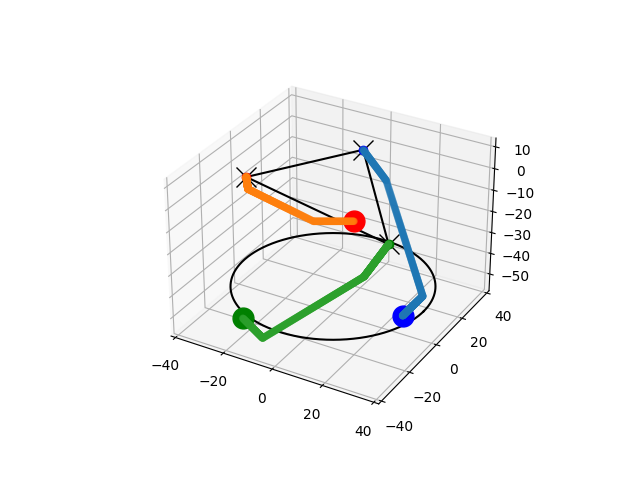

In [19]:
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
w=Wrist()
RR=R = rotation_matrix([0,20,0])
w.fix_tilt([0,20,10]).plot_3d()
plt.show()

In [20]:
print(f"{w.js[0].joint_angle()}")
print(f"{w.js[1].joint_angle()}")
print(f"{w.js[2].joint_angle()}")

[69.7]
[36.8]
[42.9]


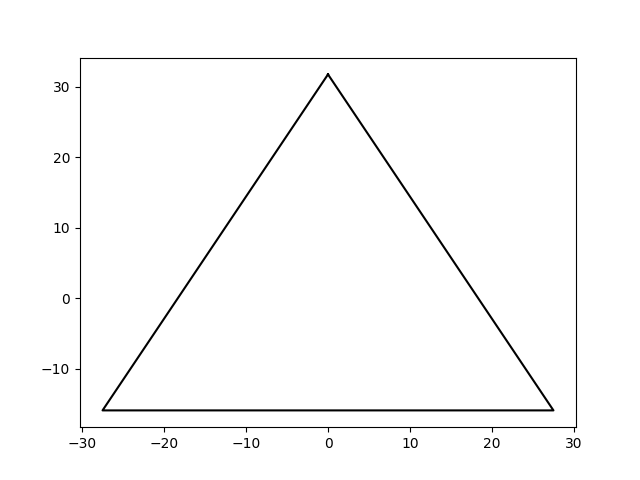

In [21]:
plt.figure();PlaneJ3().plot_2d();plt.show(); plt.gca().set_aspect(1.)

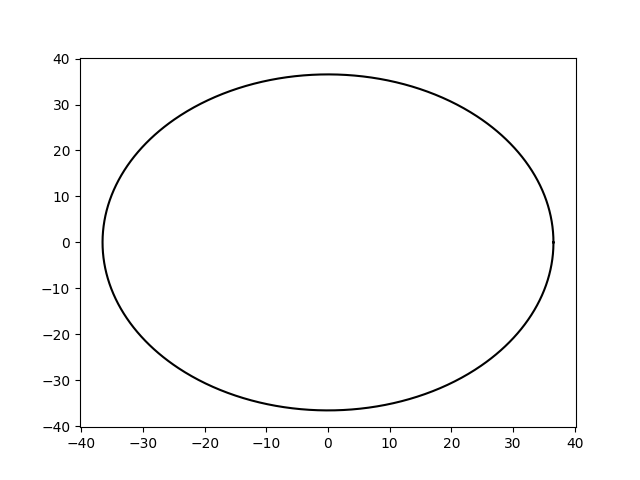

In [22]:
plt.figure();PlaneJ2().plot_2d();plt.show(); plt.gca().set_aspect(1.)

In [23]:
aa=Arm()

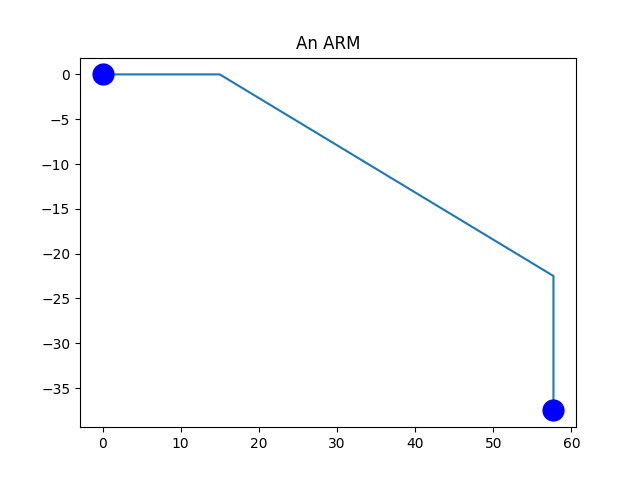

In [24]:
f = plt.figure(); Arm().plot_2d(); plt.title("An ARM"); plt.show(); plt.gca().set_aspect(1.0)

In [25]:
Ry_50 = rotation_matrix([0,50,0])

j3_dis = np.array([[0,31.75,0.]]).T

arm_mid_dis_3 = np.array([[57.7,0, 0.]]).T
arm_dis_3 = np.array([[0.,-37.5, 0.]]).T + arm_mid_dis_3

arm_mid_dis = Ry_50@arm_mid_dis_3
arm_dis = Ry_50@arm_dis_3

zero = np.array([[0,0,0]]).T

j3_loc = j3_dis + zero
j2_j3_mid_loc = arm_mid_dis + j3_dis
j2_loc = j3_dis + arm_dis

In [26]:
arm1=np.hstack([j3_dis, j2_j3_mid_loc, j2_loc])
print(arm1)

[[  0.   37.1  37.1]
 [ 31.8  31.8  -5.8]
 [  0.  -44.2 -44.2]]


In [27]:
#f = plt.figure()
#ax = f.add_subplot(111, projection='3d')
#Arm(rotation_matrix([0,50.,0]), np.array([[0, 31.75, 0]]).T).plot_3d()
#Arm(Rzp120@rotation_matrix([0,50.,0]), Rzp120@np.array([[0, 31.75, 0]]).T, color='r').plot_3d()
#Arm(Rzn120@rotation_matrix([0,50.,0]), Rzn120@np.array([[0, 31.75, 0]]).T, color='g').plot_3d()

#PlaneJ2().plot_3d()
#PlaneJ3().plot_3d()
# plt.gca().plot3D(x,y,z, c='k')
# ax.plot3D(*j2_loc,'o',c='b', ms=15)
# ax.plot3D(x[333],y[333],z[333],'o',c='g', ms=15)
# ax.plot3D(x[667],y[667],z[667],'o',c='r', ms=15)
# ax.plot3D(*arm_loc)

[This](https://gist.github.com/WesErg/285e3d6a61e242a7c0609168285a1cf7) (forked) gist explains how to add 3D arrows to matplotlib.  (Peter Ernst's gists [page](https://gist.github.com/WetHat) is just awesome).

In [28]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)


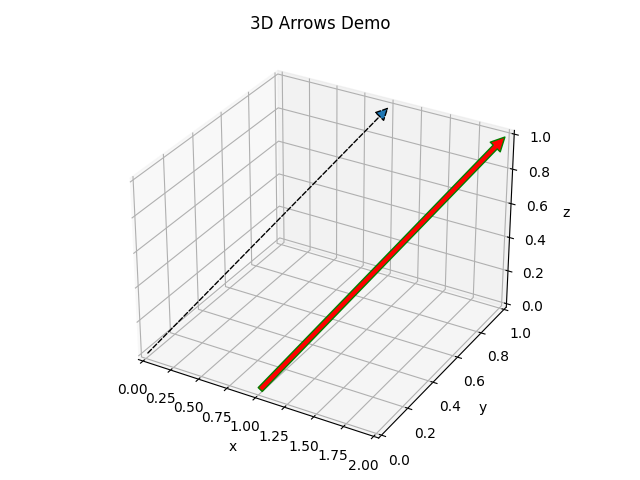

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,2)
ax.arrow3D(0,0,0,
           1,1,1,
           mutation_scale=20,
           arrowstyle="-|>",
           linestyle='dashed')
ax.arrow3D(1,0,0,
           1,1,1,
           mutation_scale=20,
           ec ='green',
           fc='red')
ax.set_title('3D Arrows Demo')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.tight_layout()